<a href="https://colab.research.google.com/github/ericPrimelles/CNAV/blob/master/Reinforcement_Learning_Class_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Approximated Methods

[Eric Primelles](eprimelles@inf.udec.cl)

**Summary**

- Approximated SARSA
- Approximated Q-Learning 

## Homework

Double Q-Learning

![](https://miro.medium.com/max/534/1*NvvRn59pz-D1iSkBWpuIxA.png) 

In [ ]:
import numpy as np
import gym

def epsilonGreedy(Q : np.float32, epsilon : float, state : int) -> int:
    
    if np.random.uniform(0, 1, 1) < epsilon:
        
        # Exploring
        
        return np.random.randint(0, len(Q[0]), 1)[0]
    
    # Greedy
    
    return np.argmax(Q[state])

def appEpsGreedy(env, Q, epsilon, state):
    
    if np.random.uniform(0, 1, 1) < epsilon:
        
        # Exploring
        
        return env.action_space.sample()
    
    # Greedy
    
    return np.argmax(Q.predict(state))


In [ ]:
def DQLearning(env: gym.Env, epsilon:float=0.7, gamma:float=0.9, episodes:int=20000, alpha : int=0.01) -> list:
    
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    Q2 = np.zeros((env.observation_space.n, env.action_space.n)) # A second Q Table is maintained
    rwd = np.zeros(episodes)
    H = 10000
    e_1 = epsilon
    for i in range(episodes):
        # Generating episode
        s = env.reset()
        print(f'Episode {i} Epsilon: {epsilon}')
        ts = 0
        while 1:
           
          a = epsilonGreedy(Q, epsilon, s)
          s_1, r, done, _ = env.step(a)
            
            
          if np.random.rand() > 0.5:
            # Update Qa
            a_1 = np.argmax(Q[s])
            Q[s, a] += alpha * (r + gamma * Q2[s_1, a_1] - Q[s, a])
          
          else:
            # Update Qb
            a_1 = np.argmax(Q2[s])
            Q2[s, a] += alpha * (r + gamma * Q[s_1, a_1] - Q2[s, a])

          s = s_1
          rwd[i] += r
          ts += 1
          if done or r == -100 or ts > H:
            epsilon -= e_1 / episodes
            break
    policy = np.argmax(Q, axis=1)
    return Q, policy, rwd


In [ ]:
env = gym.make('CliffWalking')
s = env.reset()

Q, policy, rwd = DQLearning(env, episodes= 10000)

Se han truncado las últimas 5000 líneas del flujo de salida.
Episode 5000 Epsilon: 0.3499999999999275
Episode 5001 Epsilon: 0.34992999999992747
Episode 5002 Epsilon: 0.34985999999992745
Episode 5003 Epsilon: 0.34978999999992744
Episode 5004 Epsilon: 0.3497199999999274
Episode 5005 Epsilon: 0.3496499999999274
Episode 5006 Epsilon: 0.3495799999999274
Episode 5007 Epsilon: 0.3495099999999274
Episode 5008 Epsilon: 0.34943999999992736
Episode 5009 Epsilon: 0.34936999999992735
Episode 5010 Epsilon: 0.34929999999992734
Episode 5011 Epsilon: 0.3492299999999273
Episode 5012 Epsilon: 0.3491599999999273
Episode 5013 Epsilon: 0.3490899999999273
Episode 5014 Epsilon: 0.3490199999999273
Episode 5015 Epsilon: 0.34894999999992726
Episode 5016 Epsilon: 0.34887999999992725
Episode 5017 Epsilon: 0.34880999999992723
Episode 5018 Epsilon: 0.3487399999999272
Episode 5019 Epsilon: 0.3486699999999272
Episode 5020 Epsilon: 0.3485999999999272
Episode 5021 Epsilon: 0.3485299999999272
Episode 5022 Epsilon: 0.3484

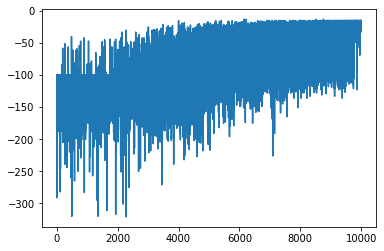

In [ ]:
env.close()

import matplotlib.pyplot as plt

plt.plot(rwd)

## Why to approximate?

What should we do when the problem grows exponetially?

How feasible are tabular solution facing huge state spaces?

**Tabular** becomes **Function**.

**Cells** becomes **Parameters**.

### Linear approximator

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRm-efjgtH-eahUd-VhP4SsC9iP7cAuMdH3-tempomGtMHFtp2kdPNZEqg7mP3E94tdGGI&usqp=CAU)

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers

In [ ]:
def linearModel(input_shape : int, output_shape : int) -> Model:
  
  inputs = layers.Input(shape=input_shape)

  actions = layers.Dense(output_shape, activation='linear')(inputs)

  return Model(inputs=inputs, outputs=actions)

In [ ]:
linearModel(3, 2).summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
Total params: 8
Trainable params: 8
Non-trainable params: 0
_________________________________________________________________


### Policy

ϵ-*Greedy*

In [ ]:

def appEpsGreedy(env : gym.Env, Q : Model, epsilon, state):
    
    if np.random.uniform(0, 1, 1) < epsilon:
        
        # Exploring
        
        return env.action_space.sample()
    
    # Greedy
    
    return np.argmax(Q.predict(state))

## Approximated SARSA

![](https://image.slidesharecdn.com/10-180722112304/95/reinforcement-learning-10-onpolicy-control-with-approximation-2-638.jpg?cb=1534204901)

In [ ]:
tf.test.is_gpu_available()

False

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
def SARSA(env:gym.Env, obs_space, action_space, epsilon:float=0.7, gamma:float=0.9, episodes:int=2000, alpha : int=0.01) -> list:
    
    # Initialize Model here
    Q = linearModel(obs_space, action_space)
    opt = SGD(alpha)
    rwd = np.zeros(episodes)
    
    e_1 = epsilon
    for i in range(episodes):
        
        # Generating episode
        s = env.reset()
        s = s.reshape((1, obs_space))
        a = appEpsGreedy(env, Q, epsilon, s)
        
        
        ts = 0
        while 1:
            
            
            s_1, r, done, _ = env.step(a)
            s_1 = s_1.reshape((1, obs_space))
            a_1 = appEpsGreedy(env, Q, epsilon, s_1)
            
            #Q[s, a] = Q[s, a] +  alpha * (r + gamma * Q[s_1, a_1] - Q[s, a])
            # SARSA Update here
            with tf.GradientTape() as tape:
              q_value = Q(s, training=True)[:, a]
              target = r + gamma * Q(s_1, training=True)[:, a_1]
              loss = target - q_value
            grad = tape.gradient(loss, Q.trainable_variables)
            opt.apply_gradients(zip(grad, Q.trainable_variables))
             
            s = s_1
            a = a_1
            
            rwd[i] += r
            ts += 1
            if done:
                print(f'Episode {i} Epsilon {epsilon} Rewards {rwd[i]}')
                epsilon -= e_1 / (episodes - 10)
                break
    
    return Q, rwd

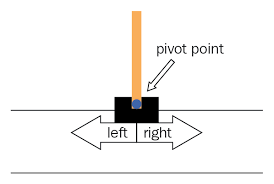

In [ ]:
env = gym.make('CartPole-v1')
env.reset()
env.observation_space.sample()

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


array([ 2.2798610e+00,  7.7221994e+37,  3.6519006e-01, -1.3367164e+38],
      dtype=float32)

In [ ]:
env.action_space.n

2

In [ ]:
Q, r = SARSA(env, len(env.observation_space.sample()), env.action_space.n)

Episode 0 Epsilon 0.7 Rewards 23.0
Episode 1 Epsilon 0.6996482412060301 Rewards 11.0
Episode 2 Epsilon 0.6992964824120602 Rewards 17.0
Episode 3 Epsilon 0.6989447236180903 Rewards 13.0
Episode 4 Epsilon 0.6985929648241205 Rewards 9.0
Episode 5 Epsilon 0.6982412060301506 Rewards 12.0
Episode 6 Epsilon 0.6978894472361807 Rewards 9.0
Episode 7 Epsilon 0.6975376884422109 Rewards 20.0
Episode 8 Epsilon 0.697185929648241 Rewards 11.0
Episode 9 Epsilon 0.6968341708542711 Rewards 14.0
Episode 10 Epsilon 0.6964824120603013 Rewards 14.0
Episode 11 Epsilon 0.6961306532663314 Rewards 14.0
Episode 12 Epsilon 0.6957788944723615 Rewards 26.0
Episode 13 Epsilon 0.6954271356783917 Rewards 18.0
Episode 14 Epsilon 0.6950753768844218 Rewards 14.0
Episode 15 Epsilon 0.6947236180904519 Rewards 19.0
Episode 16 Epsilon 0.694371859296482 Rewards 10.0
Episode 17 Epsilon 0.6940201005025122 Rewards 19.0
Episode 18 Epsilon 0.6936683417085423 Rewards 20.0
Episode 19 Epsilon 0.6933165829145724 Rewards 11.0
Episode 2

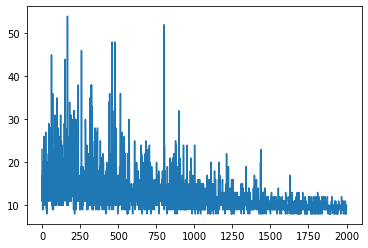

In [ ]:
plt.plot(r)

## Approximated Q-Learning

![](https://cdn.scribbr.com/wp-content/uploads/2020/10/standard-normal-distribution-1024x633.png)

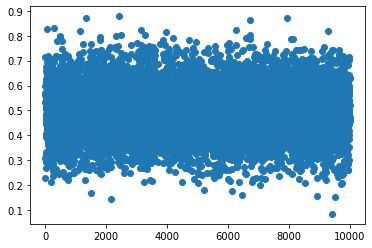

In [ ]:
mu, sigma = 0.5, 0.1
eps_gen = np.random.normal(mu,sigma, 10000)

plt.scatter(np.arange(10000),eps_gen)

In [ ]:
def QLearning(env: gym.Env, obs_space, action_space,  epsilon:float=0.7, gamma:float=0.9, episodes:int=10000, alpha : int=0.01) -> list:
    
    Q = linearModel(obs_space, action_space)
    
    opt = SGD(alpha)
    rwd = np.zeros(episodes)
    
    epsilon_gen = np.random.normal(0.5, 0.1, episodes)
    for i in range(episodes):
        epsilon = epsilon_gen[i]
        print(f'Episode {i} Epsion {epsilon}')
        # Generating episode
        s = env.reset()
        s = s.reshape((1, obs_space))
        
        
        
        ts = 0
        while 1:
            
            a = appEpsGreedy(env, Q, epsilon, s)
            s_1, r, done, _ = env.step(a)
            s_1 = s_1.reshape((1, obs_space))
            
            
            #Q[s, a] = Q[s, a] +  alpha * (r + gamma * Q[s_1, a_1] - Q[s, a])
            
            # Update Q here
            a_1 = np.argmax(Q.predict(s_1))
            
            with tf.GradientTape() as tape:
              q_value = Q(s, training=True)[:, a]
              target = r + gamma * Q(s_1, training=True)[:, a_1]
              loss = target - q_value
            grad = tape.gradient(loss, Q.trainable_variables)
            opt.apply_gradients(zip(grad, Q.trainable_variables))
            
            


            s = s_1
            
            
            rwd[i] += r
            ts += 1
            if done:
                
                
                break
    
    return Q, rwd

In [ ]:
env = gym.make('CartPole-v1')
s = env.reset()
Q, r = QLearning(env, len(env.observation_space.sample()), env.action_space.n, episodes=2000)



Episode 0 Epsion 0.44093150664776987
Episode 1 Epsion 0.5423696015957168
Episode 2 Epsion 0.3861476465018739
Episode 3 Epsion 0.5243069655642444
Episode 4 Epsion 0.5831179707167411
Episode 5 Epsion 0.460932108919873
Episode 6 Epsion 0.47319621928636685
Episode 7 Epsion 0.47683314315097386
Episode 8 Epsion 0.42948541922405825
Episode 9 Epsion 0.5742804950366582
Episode 10 Epsion 0.45933728425821324
Episode 11 Epsion 0.5001118372521713
Episode 12 Epsion 0.2904584431143321
Episode 13 Epsion 0.5277879268485169
Episode 14 Epsion 0.28107824102348106
Episode 15 Epsion 0.3856015981376569
Episode 16 Epsion 0.3524409599197533
Episode 17 Epsion 0.3503215094013422
Episode 18 Epsion 0.5457274837397725
Episode 19 Epsion 0.5732944256050282
Episode 20 Epsion 0.5485483919409309
Episode 21 Epsion 0.36459984976664894
Episode 22 Epsion 0.4203686346977016
Episode 23 Epsion 0.45795530973917886
Episode 24 Epsion 0.46867274251249796
Episode 25 Epsion 0.31736658728920847
Episode 26 Epsion 0.6102084799097198
Ep

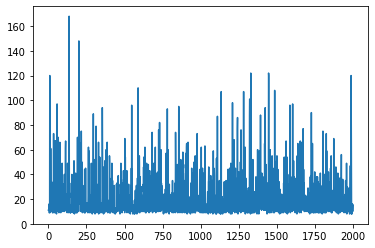

In [ ]:
plt.plot(r)